<a href="https://colab.research.google.com/github/skyshine460/music_genre/blob/main/submission_musicgenre_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [227]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [228]:
df_train = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/test.csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/genre_labels.csv")

In [229]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [230]:
# feature engineering

df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

In [231]:
print(df.isnull().sum())

index                  0
genre                  0
popularity             0
duration_ms            0
acousticness           1
positiveness          24
danceability          19
loudness               0
energy                 1
liveness               9
speechiness           19
instrumentalness       3
tempo                  0
region                 0
genre_name          4046
region_A               0
region_B               0
region_C               0
region_D               0
region_E               0
region_F               0
region_G               0
region_H               0
region_I               0
region_J               0
region_K               0
region_L               0
region_M               0
region_N               0
region_O               0
region_P               0
region_Q               0
region_R               0
region_S               0
region_T               0
region_unknown         0
num_nans               0
dtype: int64


In [232]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

numeric_columns =  [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]

# MinMaxScalerのインスタンスを作成
scaler = MinMaxScaler()

# スケーリングを実行
df_scaled_array = scaler.fit_transform(df[numeric_columns])

# 補間を行うためのKNNImputerを設定
imputer = KNNImputer(n_neighbors=2)

# k-NN補間を使用して欠損値を補完
df_imputed_array = imputer.fit_transform(df_scaled_array)

# 補完されたデータを元のスケールに逆変換
df_imputed_original = scaler.inverse_transform(df_imputed_array)

# 補完されたデータをDataFrameに戻す
df_imputed = pd.DataFrame(df_imputed_original, columns=numeric_columns)

# merged_dfの特定のカラムをdf_imputedで置き換える
df[numeric_columns] = df_imputed

# 欠損値の確認
print(df.isnull().sum())

index                  0
genre                  0
popularity             0
duration_ms            0
acousticness           0
positiveness           0
danceability           0
loudness               0
energy                 0
liveness               0
speechiness            0
instrumentalness       0
tempo                  0
region                 0
genre_name          4046
region_A               0
region_B               0
region_C               0
region_D               0
region_E               0
region_F               0
region_G               0
region_H               0
region_I               0
region_J               0
region_K               0
region_L               0
region_M               0
region_N               0
region_O               0
region_P               0
region_Q               0
region_R               0
region_S               0
region_T               0
region_unknown         0
num_nans               0
dtype: int64


In [233]:

# feature scaling

df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [234]:
df_train, df_test = split_train_test(df)
target = df_train["genre"]

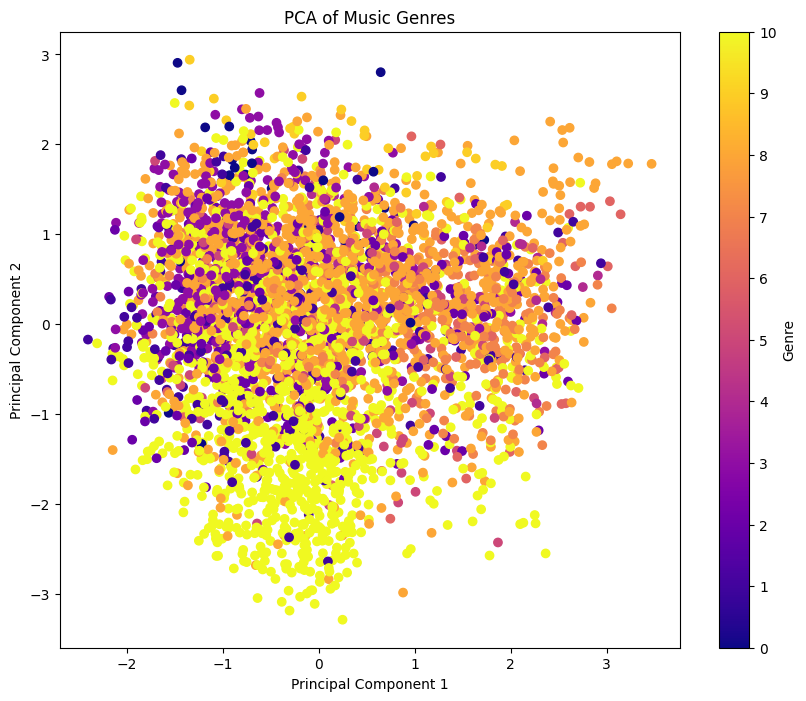

(4046, 53)


In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 特徴量のリスト
feature_num = [
            'popularity', 'acousticness', 'positiveness'
]

# 特徴量とターゲットを抽出
train_cleaned = df_train[feature_num + ['genre']]

# 特徴量とターゲット（ジャンル）を用意
train = train_cleaned.drop(columns=['genre'])  # 特徴量
y_train = train_cleaned['genre']  # ジャンルラベル

# データの標準化
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(train)

# PCAの実行
pca = PCA(n_components=2)  # 2次元に削減
pca_train_result = pca.fit_transform(df_train_scaled)

# PCAの結果をデータフレームに変換
pca_train_df = pd.DataFrame(data=pca_train_result, columns=['PC1', 'PC2'])
pca_train_df['genre'] = y_train.values  # ジャンルラベルを追加

# 可視化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_train_df['PC1'], pca_train_df['PC2'],
                      c=pca_train_df['genre'].astype('category').cat.codes, cmap='plasma')
plt.title('PCA of Music Genres')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=range(len(np.unique(y_train))), label='Genre')
plt.show()

# トレーニングデータにPCAの結果を追加
df_train = pd.concat([df_train.reset_index(drop=True), pca_train_df.reset_index(drop=True)], axis=1)
print(df_train.shape)

In [236]:
# テストデータの標準化（トレーニングデータのスケーラーを使用）
test_num = df_test[feature_num]
df_test_scaled = scaler.transform(test_num)

# テストデータにPCAを適用
pca_test_result = pca.transform(df_test_scaled)

# 結果をデータフレームに変換
pca_test_df = pd.DataFrame(data=pca_test_result, columns=['PC1', 'PC2'])

# テストデータにPCAの結果を追加（必要に応じて）
df_test = pd.concat([df_test.reset_index(drop=True), pca_test_df.reset_index(drop=True)], axis=1)

df_test.shape

(4046, 52)

In [237]:
# feature weights

features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans', 'PC1', 'PC2'
]

dict_feature_weights = {}

for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness', 'PC1', 'PC2'
]:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

feature_weights = np.array([dict_feature_weights[col] for col in features])

In [238]:
# parameters

N_CLASSES = 11
n_neighbors = 6

f1_score=0.6554092072734369

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        32
           1       0.55      0.38      0.45       205
           2       0.68      0.61      0.64       191
           3       0.81      0.71      0.76       362
           4       0.74      0.62      0.67        45
           5       0.68      0.52      0.59       126
           6       0.66      0.38      0.48        50
           7       0.62      0.55      0.58       334
           8       0.70      0.79      0.74      1305
           9       0.75      0.88      0.81        59
          10       0.77      0.80      0.78      1337

    accuracy                           0.72      4046
   macro avg       0.71      0.62      0.66      4046
weighted avg       0.72      0.72      0.72      4046



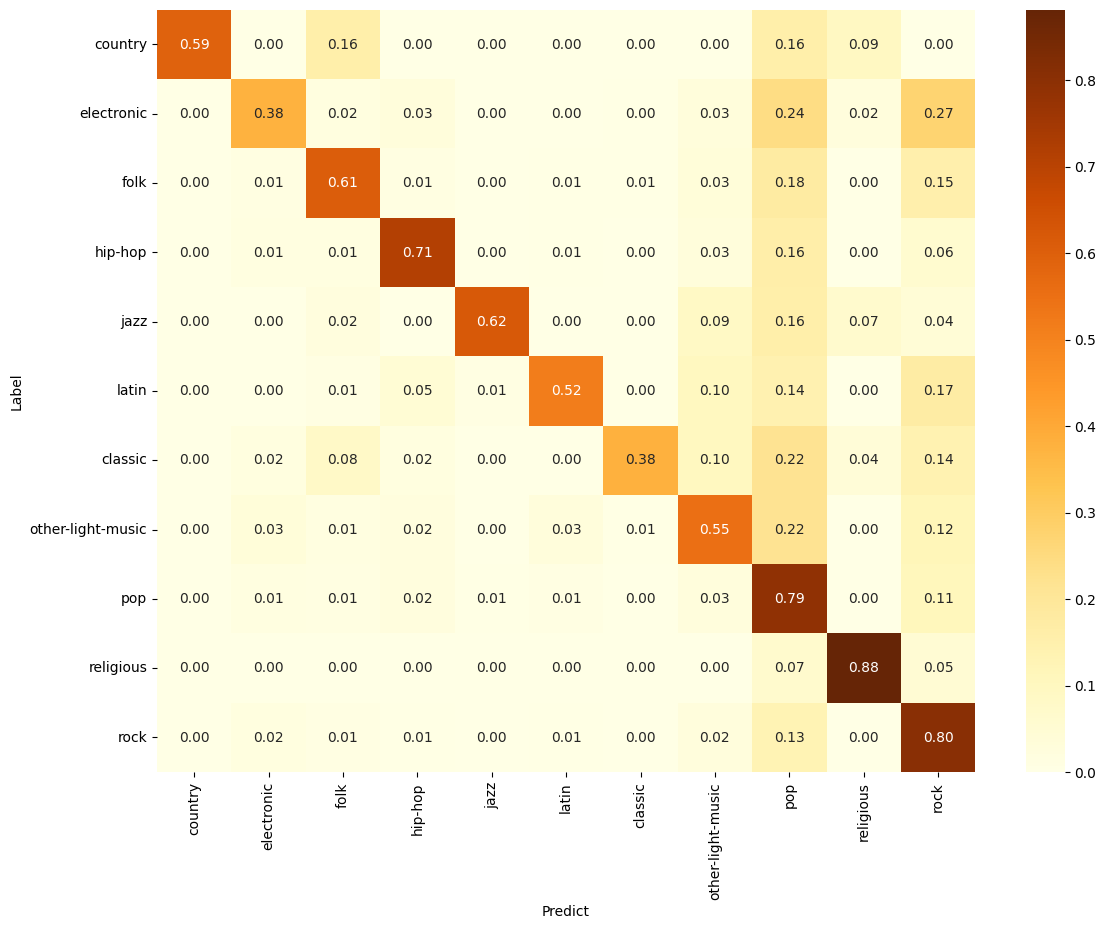

In [239]:
# cross validation

def calc_loo_cv_score():  # leave-one-out
    model = KNeighborsClassifier(n_neighbors + 1, weights="distance")
    X = df_train[features].fillna(0.0).values * feature_weights
    model.fit(X, target)
    distances, indexes = model.kneighbors(X)
    distances = distances[:, 1:]
    indexes = indexes[:, 1:]
    labels = target.values[indexes]
    preds = np.array([np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)]).argmax(1)
    score = f1_score(target, preds, average="macro")
    print(f"f1_score={score}\n")
    print(classification_report(target, preds))


    def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):
        conf = confusion_matrix(y_true=y_true,
                                y_pred=pred_label,
                                normalize='true')

        n_labels = len(conf)
        size = n_labels * height
        fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
        sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
        ax.set_ylabel('Label')
        ax.set_xlabel('Predict')

        if labels is not None:
            ax.set_yticklabels(labels)
            ax.set_xticklabels(labels)
            ax.tick_params('y', labelrotation=0)
            ax.tick_params('x', labelrotation=90)

        return fig

    fig = visualize_confusion_matrix(target, preds, labels=df_genre_labels["genre"])
    fig.show()

calc_loo_cv_score()


In [240]:
# prediction for test data

model = KNeighborsClassifier(n_neighbors, weights="distance")
X_train = df_train[features].fillna(0.0).values * feature_weights
X_test = df_test[features].fillna(0.0).values * feature_weights
model.fit(X_train, target)
df_test["prediction"] = model.predict(X_test)
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
df_submission.head(10)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [241]:
df_submission.to_csv("submission_musicgenre_14.csv", index=False, header=False)